
<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="780" height="140" align="right"/>

<p align="right">Curso: Programación Para el Analisis de datos</p>

<p align="center"> Código Curso: 203008069 </p>

<p align="center"> Grupo: 13 </p>

 <p align="center"> Tarea 3 - Exploración y visualización de datos</p>

 <p align="center">  Presentado por: Juan José García Sánchez</p>

<p align="center"> Código: 1005095836</p>

 <p align="center"> Tutor(a): Felipe Alexander Pipicano Guzman </p>

 <p align="center"> 26/11/2024</p>

 <p align="center"> UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA </p>



# Importar librerias

In [1]:
from enum import StrEnum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import pearsonr
formato = "{:.3f}"
pd.options.display.float_format = formato.format

# Funciones Estadisticas

Funciones para calcular metricas de rendimiento, y otros parametros estadisticos.

In [34]:
#las funciones definidas aqui se usaran mas adelantes en el ejercicio, son para calcular metricas y graficar

def mostrar_metricas(y_real, y_predicho, decimales = 4):
    
    mse = metrics.mean_squared_error(y_real, y_predicho)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_real, y_predicho)
    mae =  metrics.mean_absolute_error(y_real, y_predicho)
    print(
    f"R2  : {r2:.{decimales}f}",
    f"MSE : {mse:.{decimales}f}",
    f"RMSE: {rmse:.{decimales}f}",
    f"MAE : {mae:.{decimales}f}",
    sep = "\n",
    )


def matriz_confusion(y_real, y_predicho):
    matriz = metrics.confusion_matrix(y_real, y_predicho)
    heatmap(matriz, "Matriz Confusion", "d")
    ax = plt.gca()
    ax.set_xlabel("Valor Predicho")
    ax.set_ylabel("Valor Real")

def tabla_frecuencia(datos: pd.DataFrame, campo:str):
    """
    Construye una un dataframe, calculando las frecuencias 
    absolutas y relativas del campo dado.
    """
    frec = pd.crosstab(datos[campo], "frecuencia")

    relativa = frec / datos.shape[0]

    frec["relativa"] = relativa

    frec.loc["suma"] = [datos.shape[0], relativa["frecuencia"].sum()]

    return frec

def medidas_resumen(datos:pd.DataFrame, campo:str):
    """
    Calcular y mostrar en un dataframe las medidas estatisticas de 
    resumen para un campo.
    """
    res = datos[campo].describe()

    res["var"] = datos[campo].var()

    res = pd.DataFrame(res)

    return res

def tamaño_sturgess(data):
    tamaño = (np.max(data) - np.min(data)) / (1 + 3.3 * np.log10(len(data)))
    
    bins = np.arange(min(data), max(data), tamaño)

    return tamaño, bins

# Funciones de visualización

 Funciones para poder generar graficos especializados sobre el conjunto de datos.

In [3]:
def heatmap(matriz, titulo, formato=".2f", tamaño = (4, 4), mapa="Reds"):
    plt.figure(figsize=tamaño)
    sns.heatmap(matriz, annot=True, cmap=mapa, fmt=formato)
    plt.title(titulo)

# Limpieza de datos

Cargar datos a un dataframe, y eliminar los posibles datos nulos

In [4]:
# Carga los datos en un dataframe de Pandas

#limpiado de datos, el archivo csv debe estar en el mismo directorio
df_crudo = pd.read_csv('internet_municipios.csv', decimal=",", encoding="utf-8")

df_crudo.drop_duplicates()

# limpieza de los datos
df_internet = df_crudo.dropna(axis=1)

df_internet.loc[:,"DEPARTAMENTO"] = df_internet["DEPARTAMENTO"].replace('NARI�O', "NARIÑO")

# usando año, trimestre, departamento, como indices, que sera util para analisis
df_inter_agg = df_internet.set_index(["AÑO", "TRIMESTRE", "DEPARTAMENTO"])

# 1. Analisis Unidimensional

vista previa del conjunto de datos que se va a analizar

In [5]:
df_internet

,AÑO,TRIMESTRE,COD_DEPARTAMENTO,DEPARTAMENTO,COD_MUNICIPIO,MUNICIPIO,No. ACCESOS FIJOS A INTERNET,POBLACIÓN DANE,INDICE
0,2021,3,15,BOYACA,15189,CIENEGA,233,4688,0.050
1,2020,4,25,CUNDINAMARCA,25772,SUESCA,1313,18741,0.070
2,2021,3,52,NARIÑO,52036,ANCUYA,20,8601,0.002
3,2021,3,68,SANTANDER,68669,SAN ANDRES,38,8691,0.004
4,2021,1,25,CUNDINAMARCA,25040,ANOLAIMA,909,15156,0.060
...,...,...,...,...,...,...,...,...,...
13365,2022,3,76,VALLE DEL CAUCA,76670,SAN PEDRO,973,17420,0.056
13366,2022,3,25,CUNDINAMARCA,25488,NILO,316,12902,0.025
13367,2022,3,85,CASANARE,85225,NUNCHIA,93,8850,0.011
13368,2022,3,25,CUNDINAMARCA,25851,UTICA,173,4755,0.036


## 1. Clasificacion de variables en estudio:

Enumeraciones de la variables. Unicamente por facilidad de uso para referirse a las variables posteriormente, no influye en el analisis de datos.

In [6]:
class Num(StrEnum):
    año = "AÑO"
    trimestre = "TRIMESTRE"
    acc_internet = "No. ACCESOS FIJOS A INTERNET"
    pob = "POBLACIÓN DANE"
    ind = "INDICE"

class Categ(StrEnum):
    departamento = "DEPARTAMENTO"
    municipio = "MUNICIPIO" 	
    cod_dep = "COD_DEPARTAMENTO"
    cod_mun = "COD_MUNICIPIO"
 

|Variables | Descripción | Clasificación| Niveles |
|---|---|---|---|
| año | valor del año de medida | numérica | - |
| Trimestre | trimestre de la medida | numérica | - |
| Codigo de departamento | codigo asignado al departamento (DANE) | categorica | - |
| Departamento | Nombre departamento | Categorica | todos los departamentos de Colombia |
| Codigo de Municipio | codigo asignado al municipio (DANE) | categorica | - |
| Municipio | nombre del municipio | Categorica | todos los municipios de Colombia |
| Cantidad Accesos Fijos Internet | Cantidad de personas con acceso a internet en el hogar | numérica | - |
| Poblacion Dane | Población municipio (DANE) | numerica | - |
| Indice | cantidad de personas con internet / poblacion | numerica | - |


## 2. Analisis de Tendencia central, Variablidad

Se presentan a continuación un analisis basico de las variables en estudio. Para las variables numericas se hallaron los estadisticos de tendencia centra y de dispersion, para las categoricas se hallaron las tablas de frecuencia, valores unicos, y la moda.

### Categoricas

#### **Departamentos**

##### Frecuencias y Valores unicos

In [9]:
tabla_frecuencia(df_internet, Categ.departamento.value)

col_0,frecuencia,relativa
DEPARTAMENTO,,
AMAZONAS,96.000,0.007
ANTIOQUIA,1500.000,0.112
ARAUCA,84.000,0.006
ATLANTICO,276.000,0.021
BOGOTA,12.000,0.001
BOLIVAR,552.000,0.041
BOYACA,1476.000,0.110
CALDAS,324.000,0.024
CAQUETA,192.000,0.014


##### Visualización

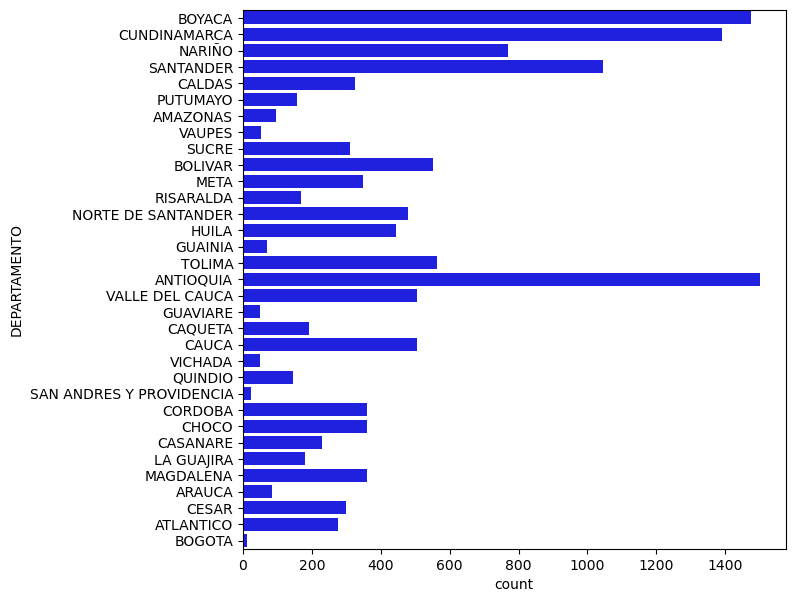

In [10]:
sns.countplot(data=df_internet, y=Categ.departamento.value, color="b", figure=plt.figure(figsize=(7,7)) )
plt.show()

##### Analisis

La tabla de frecuencia generada muestra la cantidad de mediciones que recibio cada departamento a lo largo del periodo 2019 - 2022, y los valores que toman seran los departamentos de Colombia, más la capital de Bogota, ya que se trata de forma especial. Se observa que la moda de los datos es el departamento de Antioquia, que tiene un número anormalmente alto. Le siguen  Boyaca, Cundinamarca, Santander y Nariño. Es de notar que estos departamentos estan más urbanizados que el resto.

#### **Municipio**

##### Frecuencias

In [11]:
tabla = tabla_frecuencia(df_internet, Categ.municipio.value)
display(tabla)

col_0,frecuencia,relativa
MUNICIPIO,,
ABEJORRAL,12.000,0.001
ABREGO,12.000,0.001
ABRIAQUI,12.000,0.001
ACACIAS,12.000,0.001
ACANDI,12.000,0.001
...,...,...
ZETAQUIRA,12.000,0.001
ZIPACON,12.000,0.001
ZIPAQUIRA,12.000,0.001


##### Valores Unicos

In [12]:
pd.DataFrame(df_internet[Categ.municipio].unique())

,0
0,CIENEGA
1,SUESCA
2,ANCUYA
3,SAN ANDRES
4,ANOLAIMA
...,...
1027,EL COLEGIO
1028,SANTA ROSA DEL SUR
1029,LA CEJA
1030,VIOTA


##### Visualización

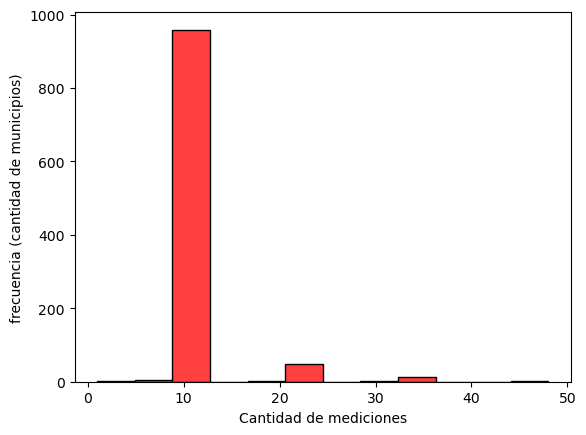

In [51]:
ax = sns.histplot(data=pd.crosstab(df_internet[Categ.municipio], "frecuencia"), x="frecuencia", color="r")

ax.set_xlabel("Cantidad de mediciones")
ax.set_ylabel("frecuencia (cantidad de municipios)")
plt.show()

##### Analisis

La tabla de frecuencia muestra la cantidad de mediciones que recibió cada municipio a lo largo del periodo 2019-2022. Su valores individuales son 1032 municipios de colombia, que es cercano al número real de 1123 municipios, dado que no todos los municipios tienen internet. La mayoria de los valores en la tabla son muy bajos para poder visualizarse correctamente en un grafico de barras, por lo que en su lugar se realizó un resumen de estas cuentas en un histograma: El eje y muestra la frecuencia los acumulados de mediciones similares, y el eje x la cantidad de mediciones. 

La grafica muestra que en el periodo 2019-2022, mayoritariamente se tomaron 9-12 mediciones en los municipios. la cantidad de municipios donde se realizaron más mediciones decrese significatimente, siendo el segundo rango más importante el de 20-25, y disminuyendo mucho más despues. Estas diferencias podrian deberse a que no puede accederse facilmente a la mayoria de municipios en Colombia, y por lo tanto predominan los valores de mediciones bajos.

#### **Codigo Departamento**

##### Frecuencias

In [14]:
tabla_frecuencia(df_internet, Categ.cod_dep)

col_0,frecuencia,relativa
COD_DEPARTAMENTO,,
5,1500.000,0.112
8,276.000,0.021
11,12.000,0.001
13,552.000,0.041
15,1476.000,0.110
17,324.000,0.024
18,192.000,0.014
19,504.000,0.038
20,300.000,0.022


##### Visualización

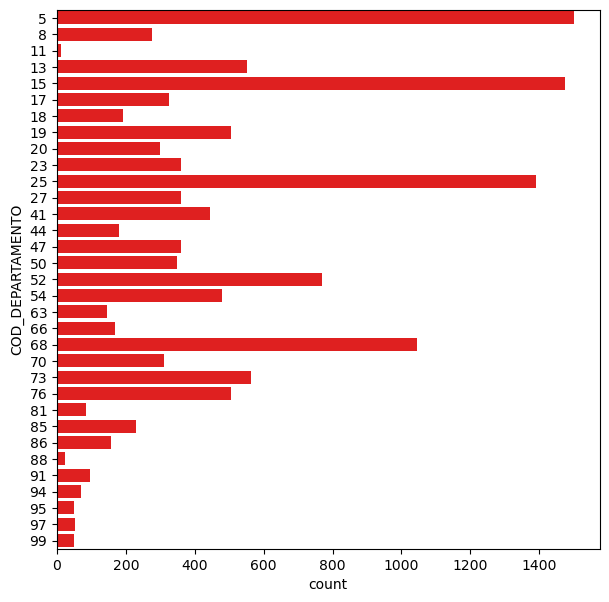

In [15]:
sns.countplot(data=df_internet, y=Categ.cod_dep, orient="v", color="r", figure=plt.figure(figsize=(7,7)) )
plt.show()

##### Analisis

El codigo del departamento solamente revela la misma información que ya se obtuvo al analizar los departamentos directamente, ya que la contabilización es la misma. Los valores de la variable seran los 1032 codigos que usa el DANE para referirse a los departamentos. No se puede aprovechar realmente esta variable categorica.

### Numericas:

#### **Año**

##### Medidas de Resumen

In [16]:
medidas_resumen(df_internet, Num.año)

,AÑO
count,13370.000
mean,2020.751
std,0.925
min,2019.000
25%,2020.000
50%,2021.000
75%,2022.000
max,2022.000
var,0.855


##### Visualización

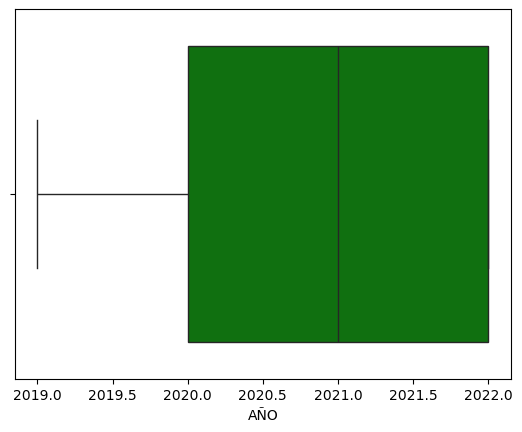

In [72]:
sns.boxplot(df_internet[Num.año.value], orient="h", color="g")
plt.show()

##### Analisis:

La medidas de la variable años muestran simplemente los años de medición del acceso a internet. El periodo de tiempo va desde el primer trimestre del 2019, hasta el tercer trimestre del años 2022. La desviación estandar de los datos es pequeña, pero la caja muestra que el 75% de los datos se encuentran entre 2020 y 2022, mostrando que la distribución esta sesgada a la derecha, y que se hicieron pocas mediciones en el año 2019. En este caso, el tope de la caja coincide con el maximo de 2022.

#### **Trimestre**

##### Medidas de Resumen

In [19]:
medidas_resumen(df_internet, Num.trimestre)

,TRIMESTRE
count,13370.000
mean,2.501
std,1.118
min,1.000
25%,2.000
50%,3.000
75%,4.000
max,4.000
var,1.250


##### Visualización

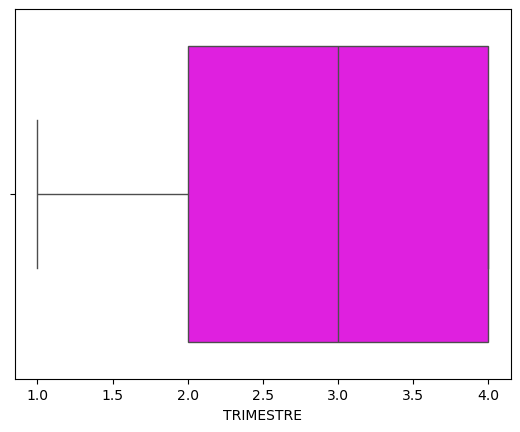

In [61]:
sns.boxplot(df_internet[Num.trimestre.value], orient="h", color="magenta", showfliers=False )
plt.show()

##### Analisis:

Los estadisticos de los valores del trimestre muestran una información similar a la distribucion del año. Se muestra que la información se concentra por encima del trimestre 2, que corresponde al año 2020, el 75% de las mediciones. La desviación estandar es de cerca de 1 trimestre, y el tope de la caja coincide con el valor maximo de trimestre 4. 

#### **Accesos fijos a Internet**

##### Medidas de Resumen

In [79]:
medidas_resumen(df_inter_agg.loc[2022], Num.acc_internet)

,No. ACCESOS FIJOS A INTERNET
count,3348.000
mean,7632.020
std,72893.957
min,1.000
25%,66.000
50%,346.000
75%,1517.000
max,2192244.000
var,5313528965.270


##### Visualización

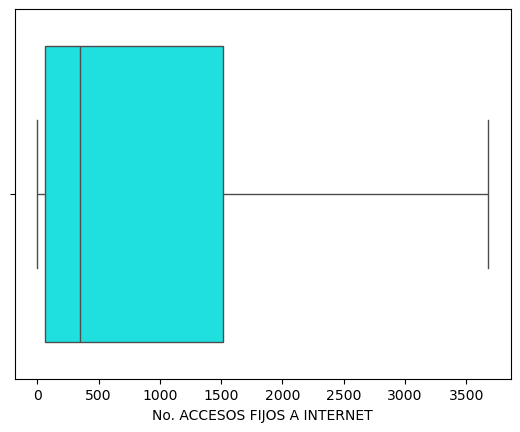

In [62]:
sns.boxplot(df_inter_agg.loc[2022][Num.acc_internet.value], orient="h", color="cyan", showfliers=False )
plt.show()

##### Analisis:

La tabla de frecuencia y el diagrama se graficaron con los datos del años mas reciente, 2022. Se observan el numero de personas en todos los municipios, que tienen accceso al internet. En promedio, 7632 personas tienen internet, y se tiene una desviación estandar de 73 mil, que es muy alta y es debida a algunos valores muy extremos. El diagrama de caja mostrado no muestra estos extremos, y revela que la distribucion esta fuertemente sesgada a la izquierda, con una mediana de 346, y valores tendiendo a ser bajos. El 75% de los registros son menores a 1500, mostrando que en la mayoria de los municipios tienen pocos accesos al internet.

#### **Población de municipios**

##### Medidas de Resumen

In [78]:
medidas_resumen(df_inter_agg.loc[2022], Num.pob.value)

,POBLACIÓN DANE
count,3348.000
mean,46238.545
std,271292.883
min,299.000
25%,6904.750
50%,13489.000
75%,28754.750
max,7901653.000
var,73599828317.881


##### Visualización

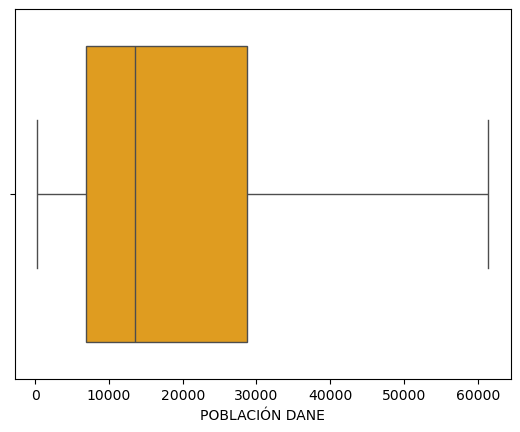

In [76]:
sns.boxplot(df_inter_agg.loc[2022][Num.pob.value], orient="h", color="orange", showfliers=False)
plt.show()

##### Analisis

La población en el conjunto de datos se refiere a la tomada por municipios por el DANE. esta se tomó a lo largo de los años, mostrando, por lo que solo se tomó como referencia el año 2022, el más reciente, para realizar la distribución. El promedio es de 46238 habitantes por municipio, y se puede ver una desviación estandar alta de 271 mil habitantes, debido a la presencia de outliers muy grandes en el dataset. 

El diagrama de caja se elaboró sin outliers, para presentar mejor los datos. El diagrama de caja muestra que un 75% de la información se concentra en menos de 30 mil habitantes, y un 25% sobre los 30 mil. La media y la mediana son muy diferentes, y se observa en el diagrama de caja que hay un sesgo hacia la izquierda, hacia valores bajos de la poblacion. Esto se debe a que la mayoria de municipios en colombia no estan densamente poblados.


#### **Indice Acceso**

##### Medidas de Resumen

In [93]:
medidas_resumen(df_inter_agg.loc[2022]*100, Num.ind.value)

,INDICE
count,3348.000
mean,5.569
std,7.075
min,0.020
25%,0.830
50%,2.920
75%,7.532
max,122.100
var,50.062


##### Visualización

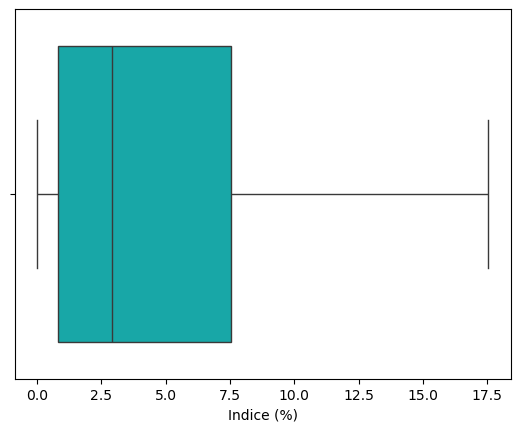

In [67]:
ax = sns.boxplot(df_inter_agg.loc[2022][Num.ind.value]*100, orient="h", color="c", showfliers=False)

ax.set_xlabel("Indice (%)")
plt.show()

##### Analisis:

Se analizaron los valores de los indices de acceso a internet del año 2022. Se multiplicaron por 100 para convertirlos en porcentajes, y visualizarlos mejor. Se obtuvo un promedio de 5.6% de acceso a internet, por municipio. El valor minimo del indice es de 0.02%, y se tiene un maximo de 122%, mostrando que en algunos casos hay mas personas con acceso a internet que la población, y que el conteo del DANE estaria desactualizado. La distribución esta sesgada fuertemente sesgada a la izquierda, tendiendo a valores bajos, estando el 75% de la información en menos del 7.5% de acceso. La caja no es simetrica, mostrando que no hay distribución normal de los datos. La distribución es consistente con la *cantidad de accesos a internet* que se evaluó previamente.

# 2. Análisis Bidimensional e Inferencial.

## 1. Graficos de dispersión de la combinaciones de variables numericas

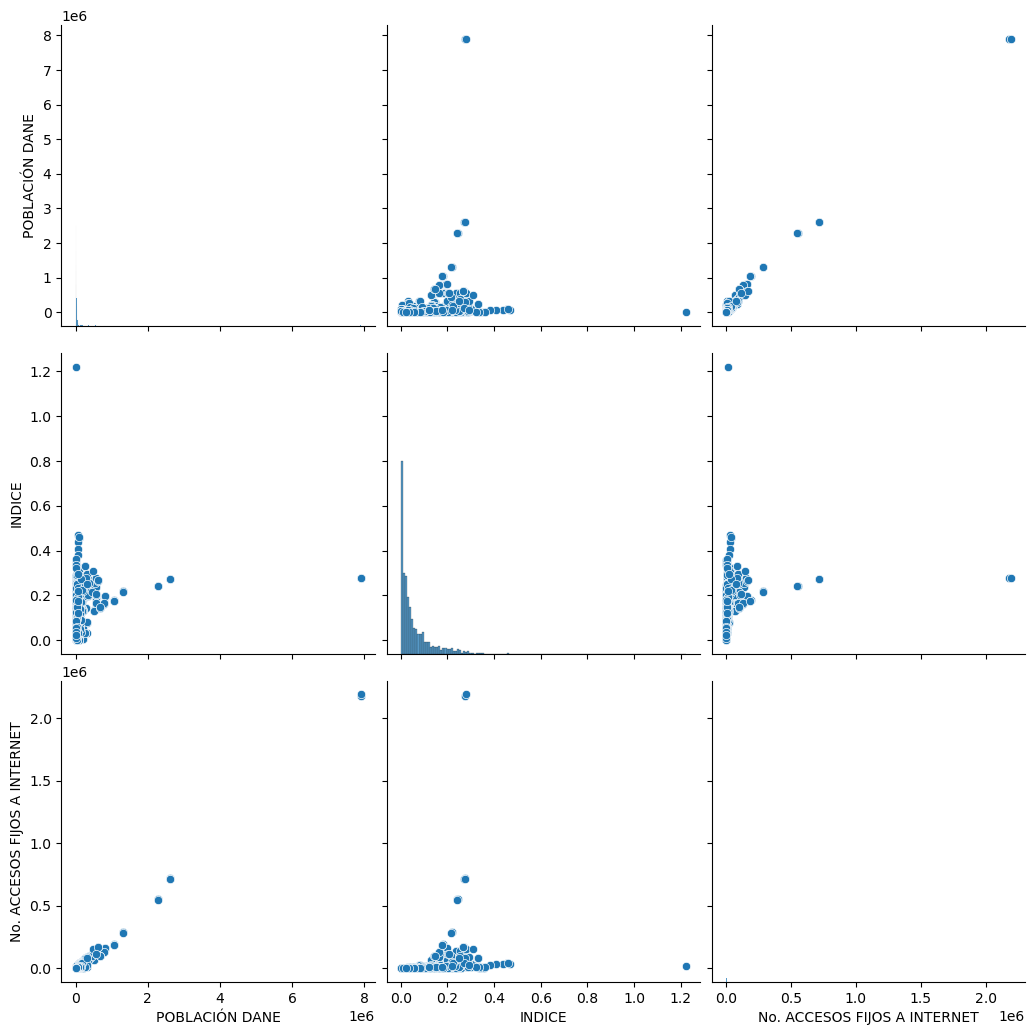

In [16]:
sns.pairplot(df_inter_agg.loc[2022][[Num.pob.value, Num.ind.value, Num.acc_internet.value]], height=3.5)
plt.show()

### Analisis de tendencias

Para poder visualizar las correlaciones entre variables, es necesario elegir un periodo de tiempo especifico. Se eligieron los datos que pertenecen al año 2022. En los graficos se observa principalmente que parece haber una correlación lineal entre la *cantidad de accesos fijos* y la *población*. Los otros pares de variables no parecen revelar relaciones.

## 2. Correlaciones Lineales

El siguiente fragmento de codigo calcula los coeficientes de correlación de pearson, y los valores *P* de la prueba de correlación asociada al mismo tiempoo.
Se hacen pares de las variables numericas en estudio secuencialmente, y toda la informacion se consigna en dos DataFrames: uno llamado  `corr` que contiene
los coeficientes, y otro llamado `valores_p` que contiene los valores p de las pruebas estadisticas.

In [52]:
variables = df_inter_agg.loc[2022][[Num.pob, Num.acc_internet, Num.ind]]

corr = pd.DataFrame(index=variables.columns, columns=variables.columns)

valores_p = corr.copy()

for variable_1 in variables.columns:
    coefs = []
    p_valores = []
 
    for variable_2 in variables.columns:
        coef, p_valor = pearsonr(variables[variable_1], variables[variable_2])
        coefs.append(coef)
        p_valores.append(p_valor)

    corr[variable_1] = coefs
    valores_p[variable_1] = p_valores

### Coeficientes de Correlación

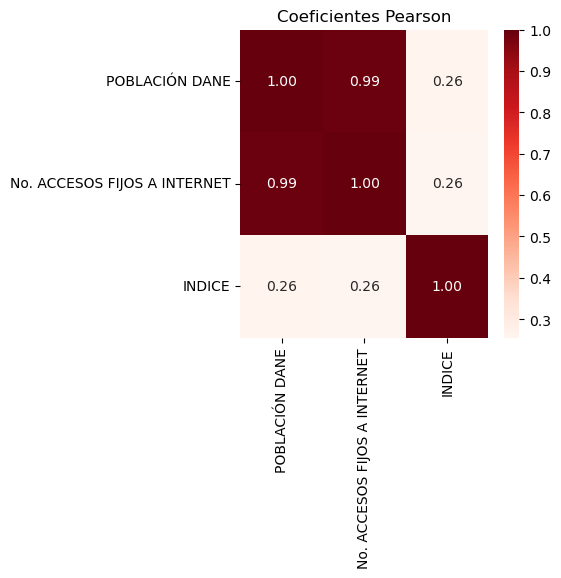

In [53]:
heatmap(corr, "Coeficientes Pearson")

### Valores P de las pruebas estadiscas de correlación

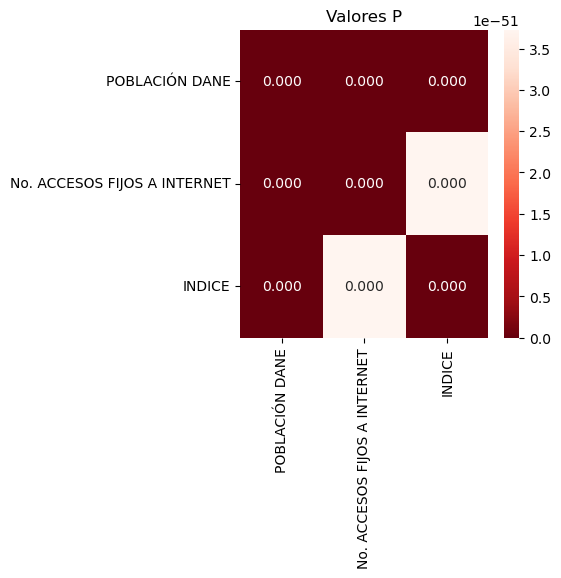

In [54]:
heatmap(valores_p, "Valores P", formato=".3f", mapa="Reds_r")

### Analisis Sobre las correlaciones:

El primer mapa de calor muestra los resultados del test de pearson. Se observa que se solo se obtuvo un valor relevante: un coeficiente de $0.99$ entre  el *número de accesos a internet fijo* y la *población municipio*. Esto sugiere que la relación es fuertemente lineal. 

En los demas pares, se observan valores de *r* bajos. Esto tiene sentido respecto al *indice* en cualquiera de los emparejamientos, ya que se usan una division simple para obtenerlo y no deberia tener relación lineal con cualquiera de las otras.

Para comprobar estos resultados, se recurre al calculo de valores *P*. Para esto hay que tener en cuenta cuales hipotesis se estan usando:
$$ H_0: \rho = 0 $$
$$ H_1: \rho \neq 0 $$

donde $\rho$ es el coeficiente de pearson de la población. Lo que significa la hipotesis nula es que las variables no tienen una correlación lineal, y estan distribuidos normalmente en la población.

Se construyó un segundo mapa para visualizar esto valores *P*, con la escala invertida para colorear más intensamente valores bajos. Se observa que todos los valores son esencialmente cero, y todos estan bajo el limite de En este caso, se rechaza la hipotesis nula, y se concluye:

- la pareja *acceso fijo internet vs población* tiene una alta posibilidad de que ambas variables tengan una correlación lineal fuerte.

- las parejas *indice vs. acceso fijo internet* y *indice vs. población municipio* tienen una relación lineal debil.

## 3. Distribuciones

### Distribución del acceso por departamento

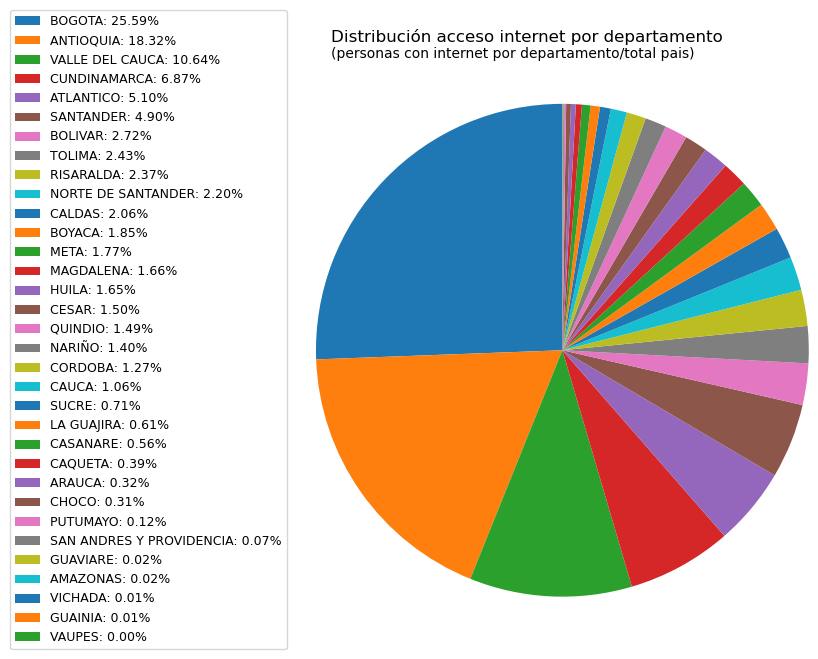

In [373]:
# realizar una agrupación por departamento
tot_por_dep = df_inter_agg.loc[2022].loc[3].groupby(Categ.departamento)[Num.acc_internet].sum()

#calcular porcentajes de internet acceso fijo por departamentos
porcentajes = tot_por_dep / tot_por_dep.sum() * 100

porcentajes = porcentajes.sort_values(ascending=False)

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1, 1, 1)

ley = [f"{dep}: {por:.2f}%" for dep, por in zip(porcentajes.index, porcentajes.values)]

ax.text(-1.5, 2, "Distribución acceso internet por departamento", fontsize=12)
ax.text(-1.5, 1.9, "(personas con internet por departamento/total pais)", fontsize=10)

patches, texts = ax.pie(porcentajes, startangle=90, radius=1.6)

ax.legend(patches, ley, bbox_to_anchor=(-0.2, 1.4), fontsize=9)

plt.show()

Para ver la distribución de las personas con internet en el pais, se eligió el periodo de tiempo mas reciente (2022, trimestre 3) y se realizó un diagrama de pastel por departamentos, con excepción de bogota que es un caso especial. Se observa que Bogota es la ciudad que mas personas con acceso a internet tiene en colombia, teniendo un poco más de una cuarta parte de las personas con acceso. Los siguientes departamentos mayoritarios son: Antioquia con el $18\%$, Valle del cauca con un $10\%$ y Cundinamarca con $7\%$, sin incluir a Bogota.

La mayoria de los departamentos tienen porcentajes en los digitos simples o decimales, indicando muy pocas personas con acceso. Esto es esperado, ya que Bogota es la ciudad capital, y los departamentos mayoritarios que lo acompañan estan uranizados, y tienen la infraestrustura suficiente para proveer la conexión a internet.

### Estandarización de las variables

Para la comparación de la variabilidad de las variables, se realizó una estandarización de las siguientes variables: *cantidad de personas con acceso internet*, *poblacion*, *indice*: Esto por medio de la clase `StandardScaler`. Despues se realizó los diagramas de caja respectivos para comparar la distribución de las variables numericas.

In [18]:
# usar columnstransformer para trasnformar las columnas necesarias unicamente
prep = ColumnTransformer([
    ("escalamiento", StandardScaler(), [Num.acc_internet.value, Num.pob.value, Num.ind.value] ),
    ],
    remainder='drop', force_int_remainder_cols=False)

display(prep)

#construir el dataframe necesario
df_inter_std = pd.DataFrame(prep.fit_transform(df_inter_agg), 
                            index=df_inter_agg.index, columns=df_inter_agg.columns[-3:])


ColumnTransformer(force_int_remainder_cols=False,
                  transformers=[('escalamiento', StandardScaler(),
                                 ['No. ACCESOS FIJOS A INTERNET',
                                  'POBLACIÓN DANE', 'INDICE'])])

In [19]:
df_inter_std

No. ACCESOS FIJOS A INTERNET  POBLACIÓN DANE  \
AÑO  TRIMESTRE DEPARTAMENTO                                                    
2021 3         BOYACA                                 -0.099          -0.153   
2020 4         CUNDINAMARCA                           -0.084          -0.100   
2021 3         NARIÑO                                 -0.102          -0.138   
               SANTANDER                              -0.102          -0.138   
     1         CUNDINAMARCA                           -0.089          -0.114   
...                                                      ...             ...   
2022 3         VALLE DEL CAUCA                        -0.089          -0.105   
               CUNDINAMARCA                           -0.098          -0.122   
               CASANARE                               -0.101          -0.137   
               CUNDINAMARCA                           -0.100          -0.153   
               SANTANDER                              -0.102          -0.162   

                                INDICE  
AÑO  TRIMESTRE DEPARTAMENTO             
2021 3         BOYACA            0.006  
2020 4         CUNDINAMARCA      0.320  
2021 3         NARIÑO           -0.722  
               SANTANDER        -0.690  
     1         CUNDINAMARCA      0.164  
...                                ...  
2022 3         VALLE DEL CAUCA   0.101  
               CUNDINAMARCA     -0.381  
               CASANARE         -0.596  
               CUNDINAMARCA     -0.198  
               SANTANDER        -0.396  

[13370 rows x 3 columns]

### Variabilidad de las caracteristicas

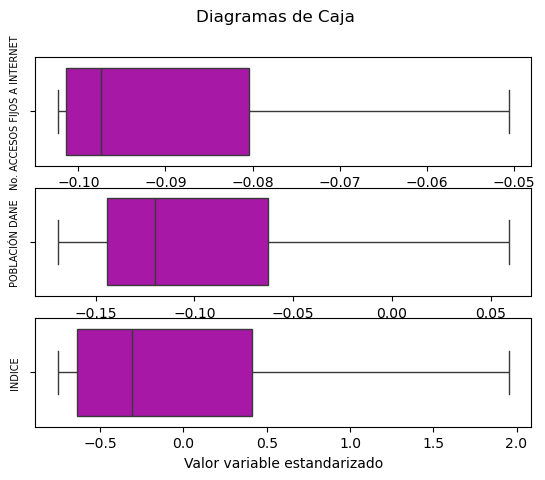

In [31]:
fig, axes = plt.subplots(3,1)

x = np.arange(0,10,10)

data = df_inter_std.loc[2022].loc[3]

plt.suptitle("Diagramas de Caja")

for i, variable in zip(range(3), data.columns):
    eje = axes[i]
    
    sns.boxplot(data=data, x=variable, color="m", showfliers=False, ax=eje)

    eje.set_ylabel(variable, fontsize=7)

eje.set_xlabel("Valor variable estandarizado")

plt.show()

##### Analisis:

Para comparar la variabilidad, se realizaron tres diagramas de caja (sin los outliers) de las variables estandarizadas. Lo primero que se puede observar es que el rango de valores es similar en el caso de la *población* y el *número de accesos fijos a internet*, y es mucho mas grande en el caso de la variable del indice de acceso, y la caja estaria mucho mas a la izquierda que lo que refleja el grafico. En los tres casos se observa que el valor maximo esta bastante separado del ultimo cuartil, y que rango de valores es mas restringido debajo del ultimo cuartil.

Las tres cajas muestran un sesgo fuerte hacia la izquierda, y se obeserva que las cajas no son simetricas, indicando que no estan distribuidos normalmente los datos. El sesgo hacia la izquierda se debe nuevamente a que la mayoria de los municipios tienen pocos accesos al internet.

### Distribución del indice de acceso

Se va a hacer una visualziación del indice de acceso a internet usando un diagrama de violin. para formar las categorias donde se van a categorizar los datos, se uso la *regla de sturges* ya que esta es adecuada para categorizar datos pequeños, y logra un equilibrio entre mostrar la variabilidad de los datos y el numero de categorias. Se obtuvieron cerca de 12 categorias, que se muestran a continuacion.

categorias: 
[2.00000000e-02 1.10606781e+01 2.21013562e+01 3.31420343e+01
 4.41827124e+01 5.52233906e+01 6.62640687e+01 7.73047468e+01
 8.83454249e+01 9.93861030e+01 1.10426781e+02 1.21467459e+02]


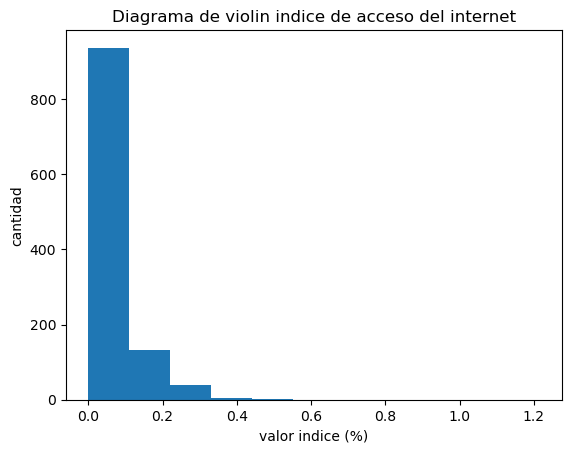

[]

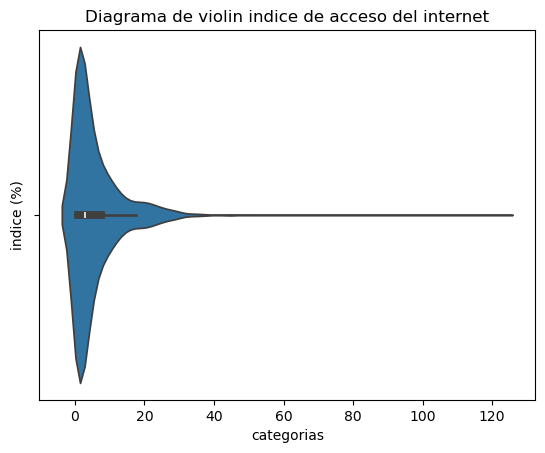

In [41]:
ind_reciente = df_inter_agg.loc[2022].loc[3][Num.ind]

tamaño, bins_sturges = tamaño_sturgess(ind_reciente)

print("categorias: ")

print(bins_sturges * 100)

plt.hist(ind_reciente, bins=bins_sturges)

plt.ylabel("cantidad")

plt.xlabel("valor indice (%)")

plt.title("Diagrama de violin indice de acceso del internet")

plt.show()


ax = sns.violinplot(ind_reciente * 100, orient="h")

ax.set_xlabel("categorias")

ax.set_ylabel("indice (%)")

ax.set_title("Diagrama de violin indice de acceso del internet")

plt.plot()

#### Analisis

El histograma del indice y el diagrama de violin se asemejan en la distribución de los valores. El histograma muestra que los valores se concentran en el rango 0 - 0.2%, y decrese a medida que se avanza en el rango. El grafico de violin muestra que la variable del indice tiene sesgo hacia la izquierda, se concentran en valores bajos, y el halo de densidad muestra que es mucho mas probable encontrar indices de acceso bajos al medir el acceso al internet en un municipio.

### Comparación de histogramas de variables numericas

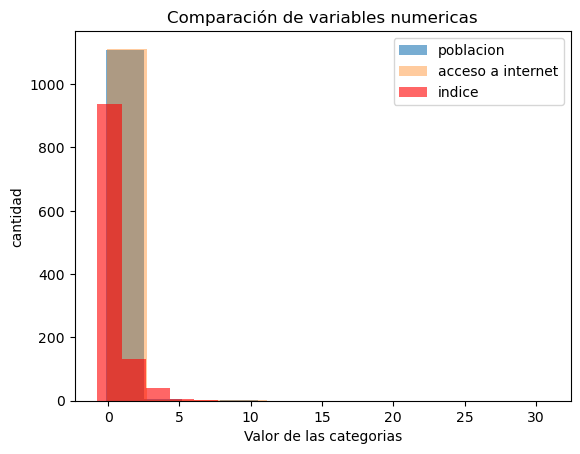

In [55]:
reciente = df_inter_std.loc[2022].loc[3]

conj_bins = []

for var in [Num.pob.value, Num.acc_internet.value, Num.ind.value]:
    tamaño, bins = tamaño_sturgess(reciente[var])
    
    conj_bins.append(bins)
    

plt.hist(reciente[Num.pob.value], bins=conj_bins[0], alpha=0.6, label="poblacion")

#graficando histograma del tiempo en el cual el motor estuvo encendido continuamente
plt.hist(reciente[Num.acc_internet.value], bins=conj_bins[1], alpha=0.4, label="acceso a internet")

#graficando histograma del tiempo en el cual la ambulancia estuvo en movimiento
plt.hist(reciente[Num.ind.value], color="r", bins=conj_bins[2], alpha=0.6, label="indice")

#ajustando titulos, mostrando leyendas y el grafico
plt.title("Comparación de variables numericas")

plt.ylabel("cantidad")

plt.xlabel("Valor de las categorias")

plt.legend()

plt.show()

#### Analisis

Los histogramas presentados se construyeron usando la regla de sturgess para determinar cuales son las categorias, y se realizo sobre las variables escaladas para hacer las comparaciones validas. Se observa que el metodo no funcina tan bien con las variables estando escaladas, ya que se generan más categorias de las que son necesarias. Se puede observar que las cantidades se concentran en valores bajos de las variables, y en la primera categoria en cada caso. Los rangos de las categorias más mayoritarias para todas las variables:

- *población* : -0.2 a 2.5.

- *cantidad de accesos a internet* : -0.2 a 2.5.

- *indice de acceso* : -0.8 a 1; y 2.5 a 4.

La distribución de los datos es consistente con las observaciones anteriores de que se concentran hacia valores bajos. Las distribuciones de la *población* y la *cantidad de datos* son casi identicos, lo cual se debe a que ambas variables estan correlacinadas entre si.

## Conclusiones

### Analisis Unidimensional

- Se encontró que las variables numericas no estan distribuidas normalmente, teniendo una distribución sesgada a la izquierda, y donde la información se encuentra concentrada en valores bajos. El número de *accesos de internet fijos* promedio es de 7632 accesos, la *población* promedio por municipios es de 46 mil personas, y el promedio del *indice* de acceso es del $5.6\%$, pero este realmente tiende a la baja.

- El dataset contiene mediciones entre los años 2019-2022, de 1032 municipios, siendo la mayoria de las mediciones entre los años 2020-2022. Se medieron municipios de todos los departamentos de colombia (Bogota se midio por separado, ya que se trata de un caso especial), y se encontro que aquellos más urbanizados son los que tienen mejor cobertura de internet: Bogota, Antioquia, Valle del Cauca, Cundinamarca (sin bogota), y santander son los primeros en la lista. El resto de los municipios tienen una cobertura muy baja del internet, mostrando la necesidad de crear politicas para el mejoramiento de la conectividad a nivel nacional.


### Analisis Bidimensional

- Se encontró una correlación lineal fuerte y positiva entre las variables de la *cantidad de accesos de internet*. Esta correlación tambien se evidenció en los graficos de dispersión realizados previmente, y tiene sentido empiricamente, ya que los municipios con más personas generalmente estan más urbanizados, y tienen un mejor acceso a internet.

- La comparación de las variables escaladas revela que todas las variables numericas tienden a sesgarse a la izquierda, y que los sesgos de la *población* y de la cantidad de accesos a internet son muy similares. La categorización de la variable *indice* revela que es mucho más probable encontrar valores bajos del *indice de acceso* al medir en los municipios.

# Referencias

- Kane, F. (2017). Hands-On Data Science and Python Machine Learning. Packt
Publishing.

- Rubio, M. (2019). Estadística con aplicaciones en R. Utadeo.
